In [ ]:
# This code block is used to access your google drive
from google.colab import drive
ROOT = "/content/drive"
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Make sure this points to the project folder

%cd drive/'My Drive'/ECE590-Final-Project

/content/drive/My Drive/ECE590-Final-Project


In [3]:
from __future__ import print_function, division

import random

import torch
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from PIL import Image
from torch.utils.tensorboard import SummaryWriter

from tools.data_loader import *
from tools.training_utils import *
from tools.initialize_model import *

In [ ]:
plots_location = '/content/drive/My Drive/ECE590-Final-Project/saved_models/saved_training_points/densenet121_fixedfeatures_ADAM_0pt01.npy'
test = np.load(plots_location,allow_pickle=True)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
test

array({'train loss': {0: 0.4555381854978986, 1: 0.24124704434849786, 2: 0.20536162950852457, 3: 0.19286398575931607, 4: 0.20760615486014858, 5: 0.21127880320787884, 6: 0.2022432377615485, 7: 0.15713935161871143, 8: 0.12153631914161335, 9: 0.12331028852181325, 10: 0.11864406653380104, 11: 0.11971934604470992, 12: 0.1138501944855898, 13: 0.12567042914186083, 14: 0.11061194392689255, 15: 0.10910837622562818, 16: 0.10885686418932913, 17: 0.10393271443150474, 18: 0.10400594338354864, 19: 0.10417316275728447, 20: 0.1077108221786808, 21: 0.10383042226611736, 22: 0.10784373852451151, 23: 0.104231694151952, 24: 0.11248605779819391}, 'train accuracy': {0: tensor(0.9175, device='cuda:0', dtype=torch.float64), 1: tensor(0.9384, device='cuda:0', dtype=torch.float64), 2: tensor(0.9461, device='cuda:0', dtype=torch.float64), 3: tensor(0.9523, device='cuda:0', dtype=torch.float64), 4: tensor(0.9483, device='cuda:0', dtype=torch.float64), 5: tensor(0.9476, device='cuda:0', dtype=torch.float64), 6: tens

In [ ]:
a = test.item()['train accuracy'].copy()

In [ ]:
def change_from_tensor_dict_to_plain(raw_dict):
  fixed = {}
  for j in raw_dict.item().keys():
    temp = raw_dict.item()[j].copy()
    for i in temp.keys():
      try:
        temp[i] = float(temp[i].cpu().numpy())
      except Exception as e:
        temp[i] = float(temp[i])
    fixed[j] = temp
  return fixed

def get_dataframes_from_training_files(raw_dict, model_name, model_version, transfer_learning_type, optimizer_type, initial_lr):
  fixed_dict = change_from_tensor_dict_to_plain(raw_dict)
  results_df = {}

  for key_value in fixed_dict.keys():
    df = pd.DataFrame(list(fixed_dict[key_value].items()),columns = ['epoch',key_value])
    df["model_long_name"] = model_name
    df["model_architecture"] = model_version
    df["transfer_learning_type"] = transfer_learning_type
    df["optimizer_type"] = optimizer_type
    df["initial_lr"] = initial_lr
    df["process"] = key_value
    results_df.update({key_value : df})
  return results_df

def get_config_from_name(filename,model_versions=['wide_resnet50_2','densenet121','resnet18','resnet50','resnext101_32x8d','squeezenet1_0','vgg19_bn']):

  for model_version in model_versions:
    
    if model_version in filename:
      result = filename.replace('.npy','').replace(model_version+'_','').replace('pt','.').split("_")

      if result[0] == 'hybridfixedfeatures':
        result[0] = 'Hybrid'
      elif result[0] == 'fixedfeatures':
        result[0] = 'Fixed Features'
      elif result[0] == 'finetune':
        result[0] = 'Finetune'

      return filename.replace('.npy',''),model_version ,result[0], result[1], float(result[2])


def create_csv_files_saved_points(directory):
  results = pd.DataFrame(columns = ["model_long_name","model_architecture","transfer_learning_type", 
                          "optimizer_type","initial_lr","process","epoch","model_performance"])
  cnt = 0
  for filename in os.listdir(directory):
      if filename.endswith(".npy"):
        plots_location = os.path.join(directory, filename)
        model_points = np.load(plots_location,allow_pickle=True)

        model_full_name, model_version, transfer_learning_type, optimizer_type, initial_lr = get_config_from_name(filename = filename)
        model_result = get_dataframes_from_training_files(raw_dict = model_points, 
                                                          model_name = model_full_name, 
                                                          model_version = model_version, 
                                                          transfer_learning_type = transfer_learning_type, 
                                                          optimizer_type = optimizer_type, 
                                                          initial_lr = initial_lr)

        for key in model_result.keys():
          results = results.append(pd.DataFrame({"model_long_name": model_result[key]["model_long_name"],
                                    "model_architecture": model_result[key]["model_architecture"],
                                    "transfer_learning_type": model_result[key]["transfer_learning_type"], 
                                    "optimizer_type": model_result[key]["optimizer_type"],
                                    "initial_lr": model_result[key]["initial_lr"],
                                    "process": model_result[key]["process"],
                                    "epoch": model_result[key]['epoch'],
                                    "model_performance": model_result[key][key]
                                    }), ignore_index=True)
      else:
          continue
      cnt += 1
      if cnt == 100000000:
        return results
  results.to_csv(os.path.join(directory, 'model_performance.csv'), index = False)
  return results


In [ ]:
#test_df2 =get_dataframes_from_training_files(raw_dict=test, model_name='Model test',model_version='test', transfer_learning_type='test', optimizer_type='SGD', initial_lr=0.01)
#test_df2['validation accuracy']

directory = r'/content/drive/My Drive/ECE590-Final-Project/saved_models/saved_training_points/'
results = create_csv_files_saved_points(directory)

In [ ]:
#results.tail(50)
results[(results['process']=='validation accuracy') & (results['initial_lr']==0.1)].head(50)

,model_long_name,model_architecture,transfer_learning_type,optimizer_type,initial_lr,process,epoch,model_performance
75,resnet18_hybridfixedfeatures_SGD_0pt1,resnet18,Hybrid,SGD,0.1,validation accuracy,0,0.968843
76,resnet18_hybridfixedfeatures_SGD_0pt1,resnet18,Hybrid,SGD,0.1,validation accuracy,1,0.828817
77,resnet18_hybridfixedfeatures_SGD_0pt1,resnet18,Hybrid,SGD,0.1,validation accuracy,2,0.975051
78,resnet18_hybridfixedfeatures_SGD_0pt1,resnet18,Hybrid,SGD,0.1,validation accuracy,3,0.976603
79,resnet18_hybridfixedfeatures_SGD_0pt1,resnet18,Hybrid,SGD,0.1,validation accuracy,4,0.974931
80,resnet18_hybridfixedfeatures_SGD_0pt1,resnet18,Hybrid,SGD,0.1,validation accuracy,5,0.973976
81,resnet18_hybridfixedfeatures_SGD_0pt1,resnet18,Hybrid,SGD,0.1,validation accuracy,6,0.979348
82,resnet18_hybridfixedfeatures_SGD_0pt1,resnet18,Hybrid,SGD,0.1,validation accuracy,7,0.980423
83,resnet18_hybridfixedfeatures_SGD_0pt1,resnet18,Hybrid,SGD,0.1,validation accuracy,8,0.981139
84,resnet18_hybridfixedfeatures_SGD_0pt1,resnet18,Hybrid,SGD,0.1,validation accuracy,9,0.980900


In [4]:
result_df = pd.read_csv('/content/drive/My Drive/ECE590-Final-Project/saved_models/saved_training_points/model_performance.csv')

In [ ]:
result_df.head()

,model_long_name,model_architecture,transfer_learning_type,optimizer_type,initial_lr,process,epoch,model_performance
0,resnet18_hybridfixedfeatures_SGD_0pt1,resnet18,Hybrid,SGD,0.1,train loss,0,0.520245
1,resnet18_hybridfixedfeatures_SGD_0pt1,resnet18,Hybrid,SGD,0.1,train loss,1,0.301994
2,resnet18_hybridfixedfeatures_SGD_0pt1,resnet18,Hybrid,SGD,0.1,train loss,2,0.285864
3,resnet18_hybridfixedfeatures_SGD_0pt1,resnet18,Hybrid,SGD,0.1,train loss,3,0.258693
4,resnet18_hybridfixedfeatures_SGD_0pt1,resnet18,Hybrid,SGD,0.1,train loss,4,0.251384


In [ ]:
result_df.loc[(result_df['process']=='validation accuracy') & (result_df['initial_lr']==0.1),:]

,model_long_name,model_architecture,transfer_learning_type,optimizer_type,initial_lr,process,epoch,model_performance
75,resnet18_hybridfixedfeatures_SGD_0pt1,resnet18,Hybrid,SGD,0.1,validation accuracy,0,0.968843
76,resnet18_hybridfixedfeatures_SGD_0pt1,resnet18,Hybrid,SGD,0.1,validation accuracy,1,0.828817
77,resnet18_hybridfixedfeatures_SGD_0pt1,resnet18,Hybrid,SGD,0.1,validation accuracy,2,0.975051
78,resnet18_hybridfixedfeatures_SGD_0pt1,resnet18,Hybrid,SGD,0.1,validation accuracy,3,0.976603
79,resnet18_hybridfixedfeatures_SGD_0pt1,resnet18,Hybrid,SGD,0.1,validation accuracy,4,0.974931
...,...,...,...,...,...,...,...,...
11795,vgg19_bn_hybridfixedfeatures_ADAM_0pt1,vgg19_bn,Hybrid,ADAM,0.1,validation accuracy,20,0.967888
11796,vgg19_bn_hybridfixedfeatures_ADAM_0pt1,vgg19_bn,Hybrid,ADAM,0.1,validation accuracy,21,0.967888
11797,vgg19_bn_hybridfixedfeatures_ADAM_0pt1,vgg19_bn,Hybrid,ADAM,0.1,validation accuracy,22,0.967888
11798,vgg19_bn_hybridfixedfeatures_ADAM_0pt1,vgg19_bn,Hybrid,ADAM,0.1,validation accuracy,23,0.967888


# Visualizations

## Comparing different transfer learning methods

In [ ]:
def find_interesting_curves():
  for 

def plot_graphs():
  fig = make_subplots(rows=2, cols=2, start_cell="bottom-left")

  fig.add_trace(go.Scatter(x=[1, 2, 3], y=[4, 5, 6]),
                row=1, col=1)

  fig.add_trace(go.Scatter(x=[20, 30, 40], y=[50, 60, 70]),
                row=1, col=2)

  fig.add_trace(go.Scatter(x=[300, 400, 500], y=[600, 700, 800]),
                row=2, col=1)

  fig.add_trace(go.Scatter(x=[4000, 5000, 6000], y=[7000, 8000, 9000]),
                row=2, col=2)

  fig.show()

SyntaxError: ignored

In [ ]:

fig = go.Figure()

for model_name in result_df[(result_df['process']=='validation accuracy') & (result_df['initial_lr']==0.01)]['model_long_name'].unique():
  epoch = result_df[(result_df['model_long_name']==model_name) & (result_df['process']=='validation accuracy')]['epoch'].copy()
  model_result = result_df[(result_df['model_long_name']==model_name) & (result_df['process']=='validation accuracy') & (result_df['initial_lr']==0.01)]['model_performance'].copy()
  #print(model_result.max(),model_result.min())
  fig.add_trace(go.Scatter(x=epoch, y=model_result, mode='lines', name=model_name))
# Edit the layout
fig.update_layout(title='Learning curve of Attention and L2I models and a combination of the two',
                   xaxis_title='Training time (hours)',
                   yaxis_title='Average tour distance',
                  yaxis=dict(range=[0.95,1]))

fig.show()

fig2 = go.Figure()
for model_name in result_df[(result_df['process']=='train loss') & (result_df['initial_lr']==0.01)]['model_long_name'].unique():
  epoch = result_df[(result_df['model_long_name']==model_name) & (result_df['process']=='train loss')]['epoch'].copy()
  model_result = result_df[(result_df['model_long_name']==model_name) & (result_df['process']=='train loss') & (result_df['initial_lr']==0.01)]['model_performance'].copy()
  #print(model_result.max(),model_result.min())
  fig2.add_trace(go.Scatter(x=epoch, y=model_result, mode='lines', name=model_name))
# Edit the layout
fig2.update_layout(title='Learning curve of Attention and L2I models and a combination of the two',
                   xaxis_title='Training time (hours)',
                   yaxis_title='Average tour distance',
                  yaxis=dict(range=[0,3]))

fig2.show()

fig3 = go.Figure()
for model_name in result_df[(result_df['process']=='train loss')]['model_long_name'].unique():
  epoch = result_df[(result_df['model_long_name']==model_name) & (result_df['process']=='train loss')]['epoch'].copy()
  model_result = result_df[(result_df['model_long_name']==model_name) & (result_df['process']=='train loss')]['model_performance'].copy()
  #print(model_result.max(),model_result.min())
  fig3.add_trace(go.Scatter(x=epoch, y=model_result, mode='lines', name=model_name))
# Edit the layout
fig3.update_layout(title='Learning curve of Attention and L2I models and a combination of the two',
                   xaxis_title='Training time (hours)',
                   yaxis_title='Average tour distance',
                  yaxis=dict(range=[0,3]))

fig3.show()

## Effect of size of model

## Effect of optimization algorithms

In [ ]:
fig2 = go.Figure()
for model_name in result_df[(result_df['process']=='train loss') & (result_df['optimizer_type']=='SGD')]['model_long_name'].unique():
  epoch = result_df[(result_df['model_long_name']==model_name) & (result_df['process']=='train loss')]['epoch'].copy()
  model_result = result_df[(result_df['model_long_name']==model_name) & (result_df['process']=='train loss') & (result_df['optimizer_type']=='SGD')]['model_performance'].copy()
  #print(model_result.max(),model_result.min())
  fig2.add_trace(go.Scatter(x=epoch, y=model_result, mode='lines', name=model_name))
# Edit the layout
fig2.update_layout(title='Learning curve of models trained with SGD optimizer',
                   xaxis_title='Epoch',
                   yaxis_title='Loss',
                  yaxis=dict(range=[0,5]))

fig2.show()

fig2 = go.Figure()
for model_name in result_df[(result_df['process']=='train loss') & (result_df['optimizer_type']=='ADAM')]['model_long_name'].unique():
  epoch = result_df[(result_df['model_long_name']==model_name) & (result_df['process']=='train loss')]['epoch'].copy()
  model_result = result_df[(result_df['model_long_name']==model_name) & (result_df['process']=='train loss') & (result_df['optimizer_type']=='ADAM')]['model_performance'].copy()
  #print(model_result.max(),model_result.min())
  fig2.add_trace(go.Scatter(x=epoch, y=model_result, mode='lines', name=model_name))
# Edit the layout
fig2.update_layout(title='Learning curve of models trained with ADAM optimizer',
                   xaxis_title='Epoch',
                   yaxis_title='Loss',
                  yaxis=dict(range=[0,5]))

fig2.show()

## Effect of learning rate on transfer

In [ ]:
fig2 = go.Figure()
for model_name in result_df[(result_df['process']=='train loss') & (result_df['initial_lr']==0.1)]['model_long_name'].unique():
  epoch = result_df[(result_df['model_long_name']==model_name) & (result_df['process']=='train loss')]['epoch'].copy()
  model_result = result_df[(result_df['model_long_name']==model_name) & (result_df['process']=='train loss') & (result_df['initial_lr']==0.1)]['model_performance'].copy()
  #print(model_result.max(),model_result.min())
  fig2.add_trace(go.Scatter(x=epoch, y=model_result, mode='lines', name=model_name))
# Edit the layout
fig2.update_layout(title='Learning curve of learning rate = 0.1',
                   xaxis_title='Epoch',
                   yaxis_title='Loss',
                  yaxis=dict(range=[0,3]))

fig2.show()

fig2 = go.Figure()
for model_name in result_df[(result_df['process']=='train loss') & (result_df['initial_lr']==0.01)]['model_long_name'].unique():
  epoch = result_df[(result_df['model_long_name']==model_name) & (result_df['process']=='train loss')]['epoch'].copy()
  model_result = result_df[(result_df['model_long_name']==model_name) & (result_df['process']=='train loss') & (result_df['initial_lr']==0.01)]['model_performance'].copy()
  #print(model_result.max(),model_result.min())
  fig2.add_trace(go.Scatter(x=epoch, y=model_result, mode='lines', name=model_name))
# Edit the layout
fig2.update_layout(title='Learning curve of learning rate = 0.01',
                   xaxis_title='Epoch',
                   yaxis_title='Loss',
                  yaxis=dict(range=[0,3]))

fig2.show()

fig2 = go.Figure()
for model_name in result_df[(result_df['process']=='train loss') & (result_df['initial_lr']==0.001)]['model_long_name'].unique():
  epoch = result_df[(result_df['model_long_name']==model_name) & (result_df['process']=='train loss')]['epoch'].copy()
  model_result = result_df[(result_df['model_long_name']==model_name) & (result_df['process']=='train loss') & (result_df['initial_lr']==0.001)]['model_performance'].copy()
  #print(model_result.max(),model_result.min())
  fig2.add_trace(go.Scatter(x=epoch, y=model_result, mode='lines', name=model_name))
# Edit the layout
fig2.update_layout(title='Learning curve of learning rate = 0.001',
                   xaxis_title='Epoch',
                   yaxis_title='Loss',
                  yaxis=dict(range=[0,3]))

fig2.show()



(0.9, 1.0)

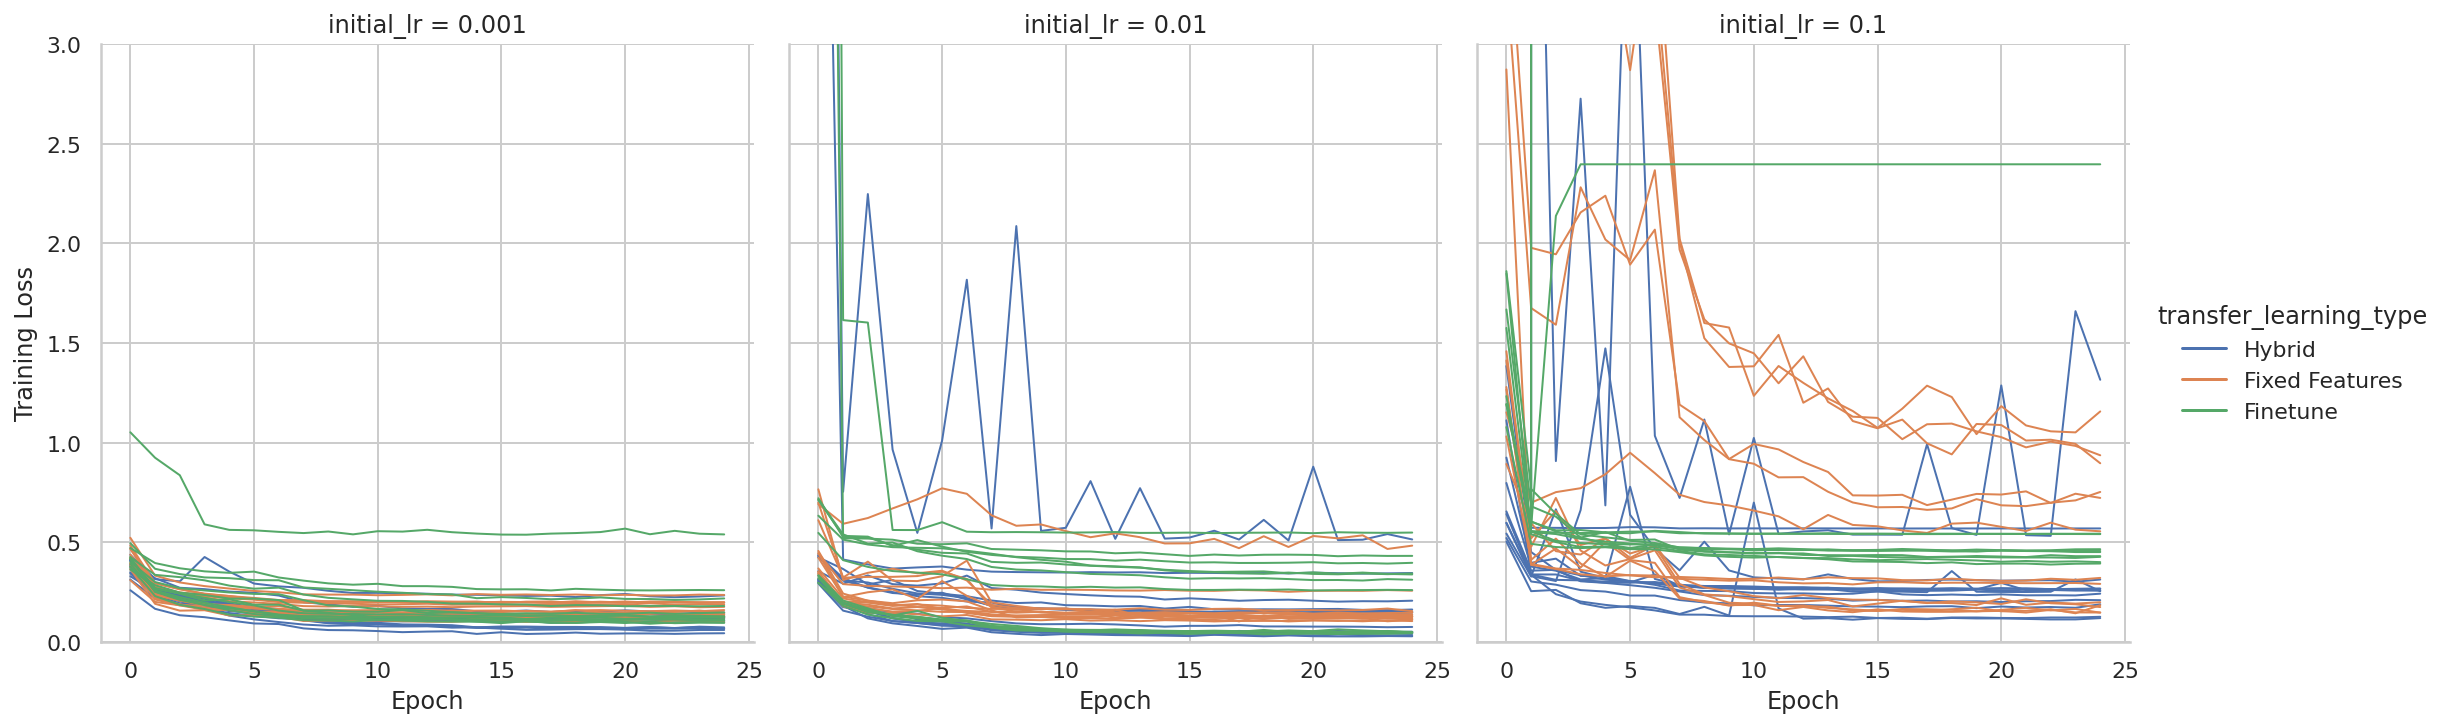

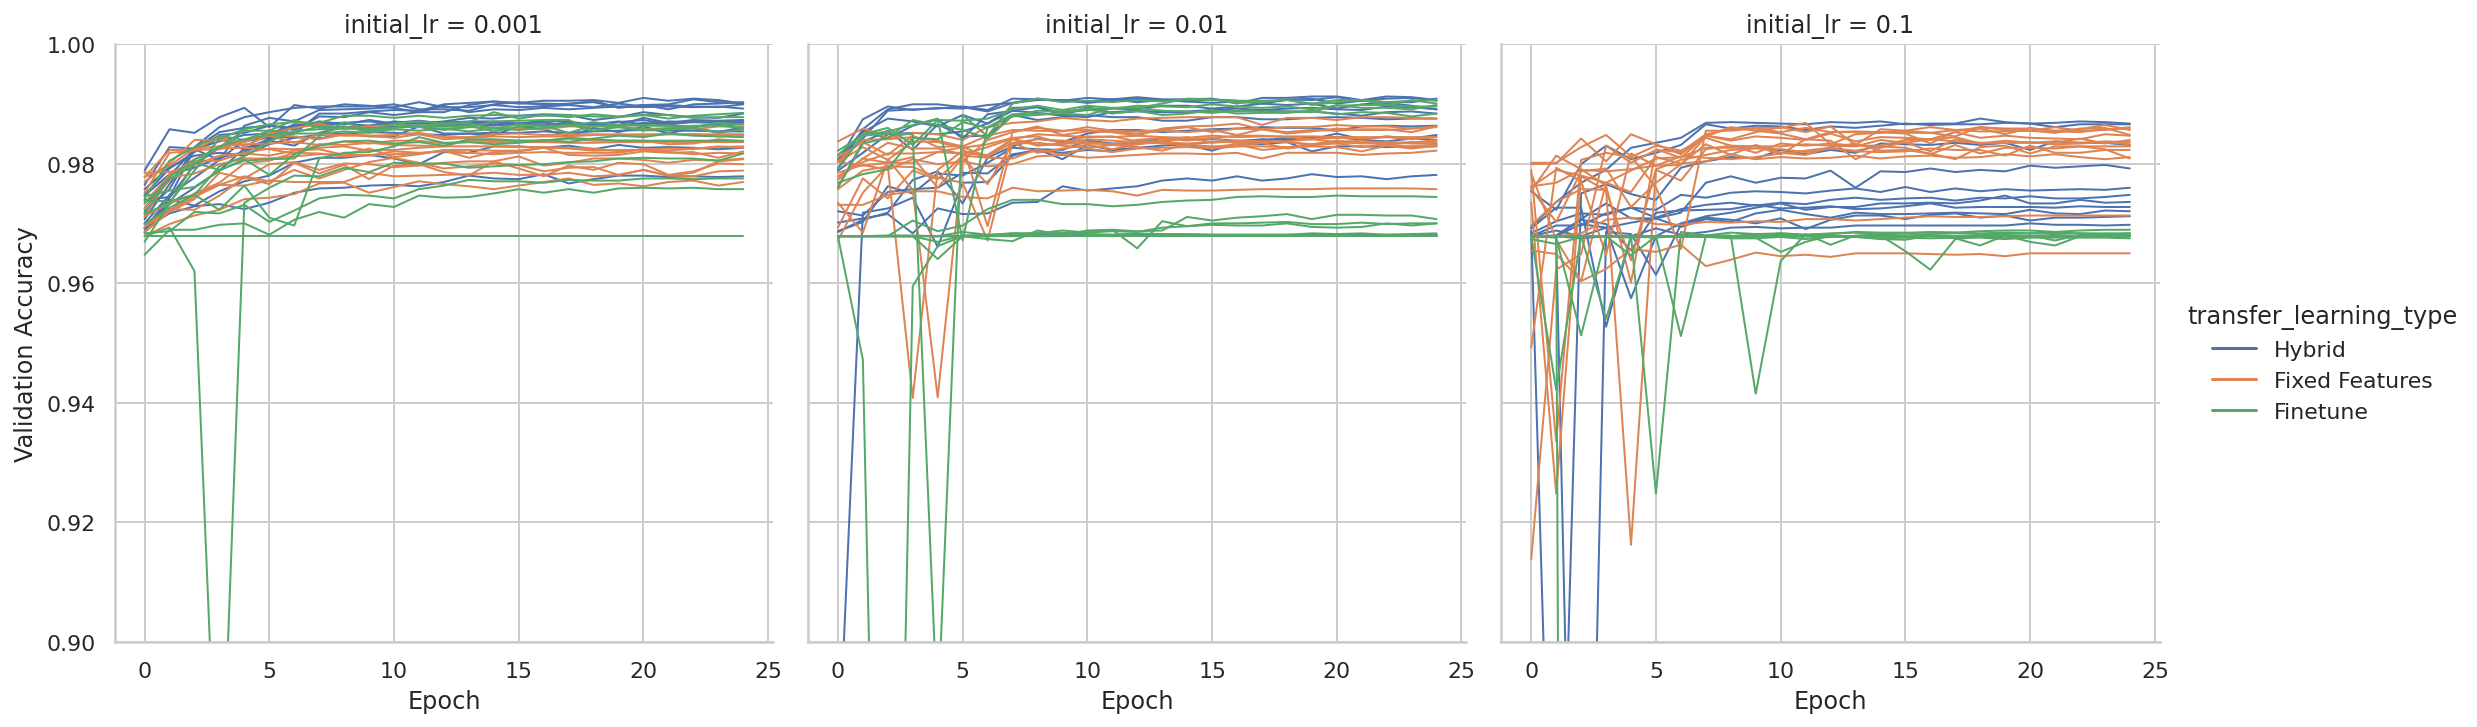

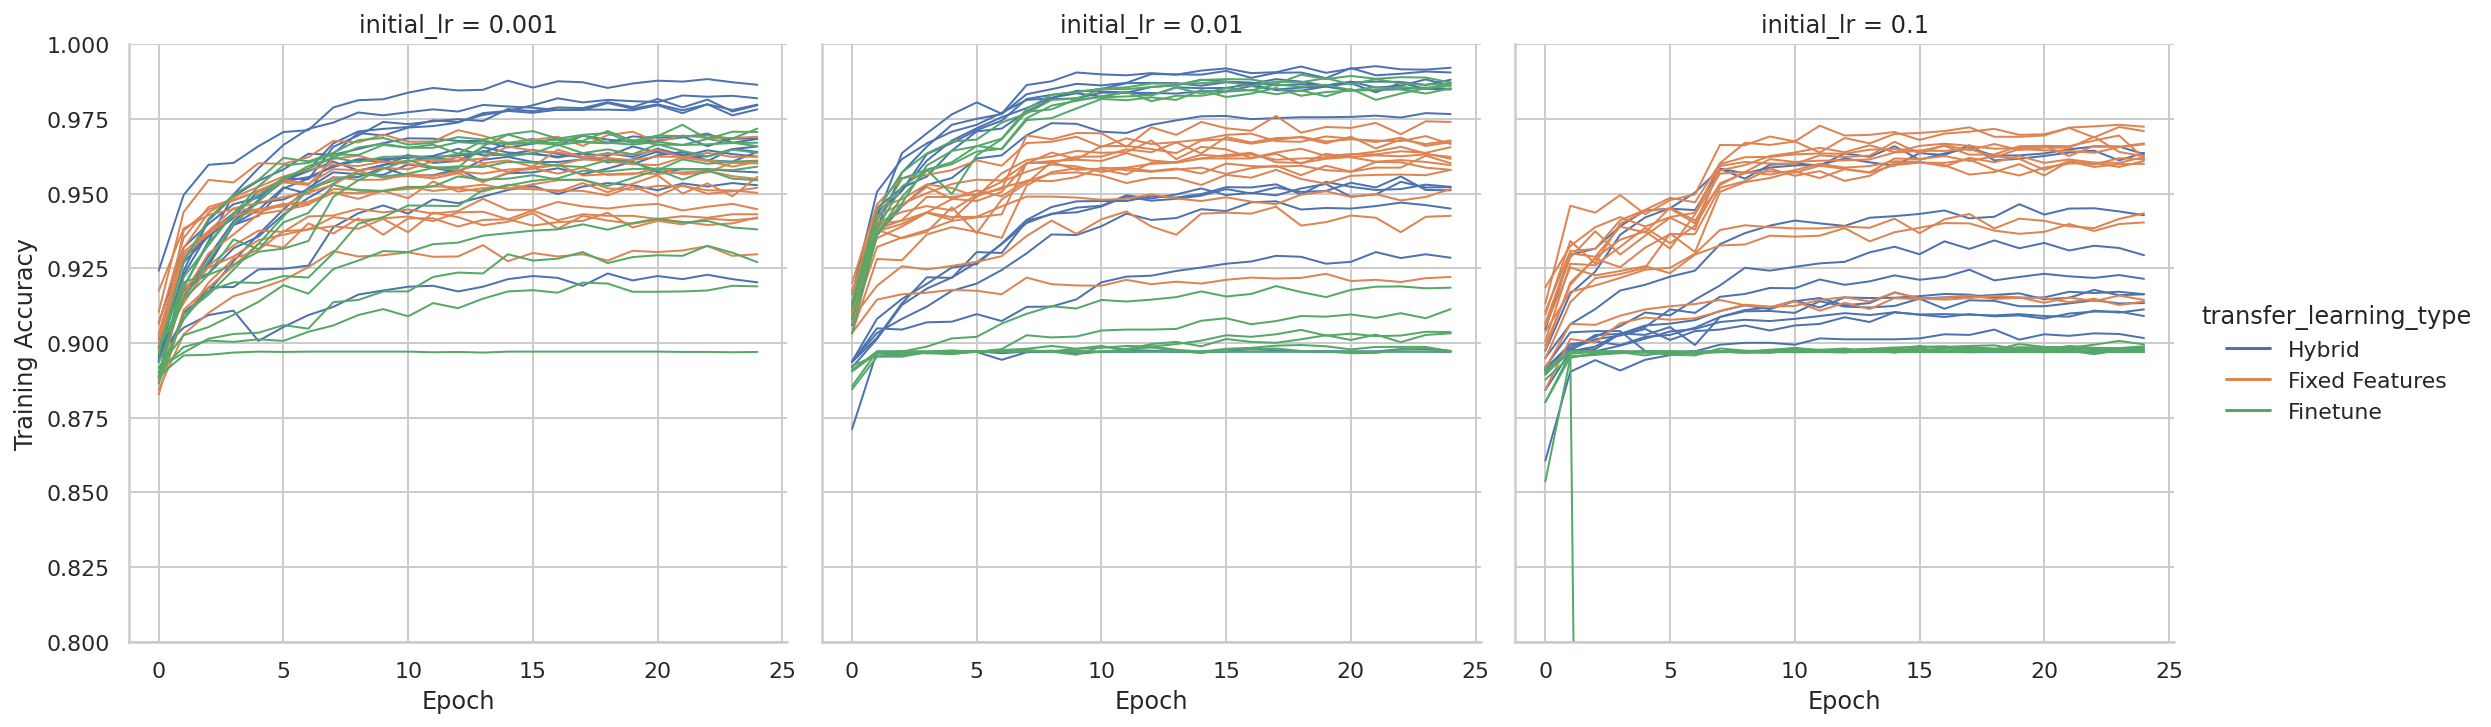

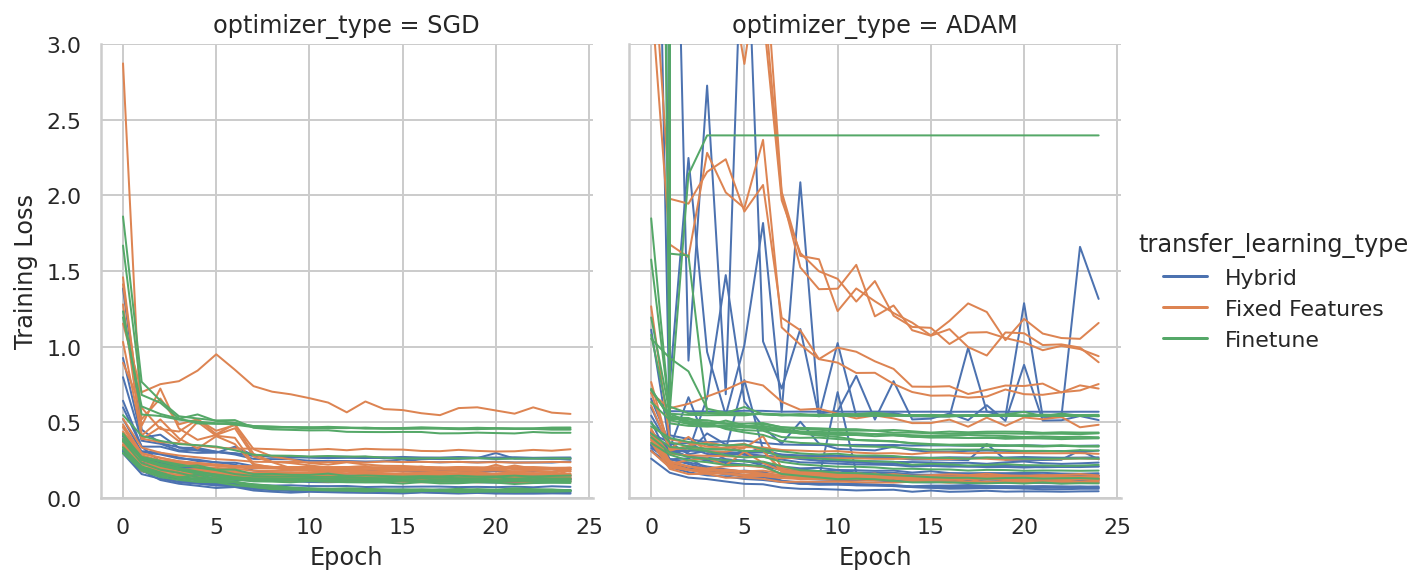

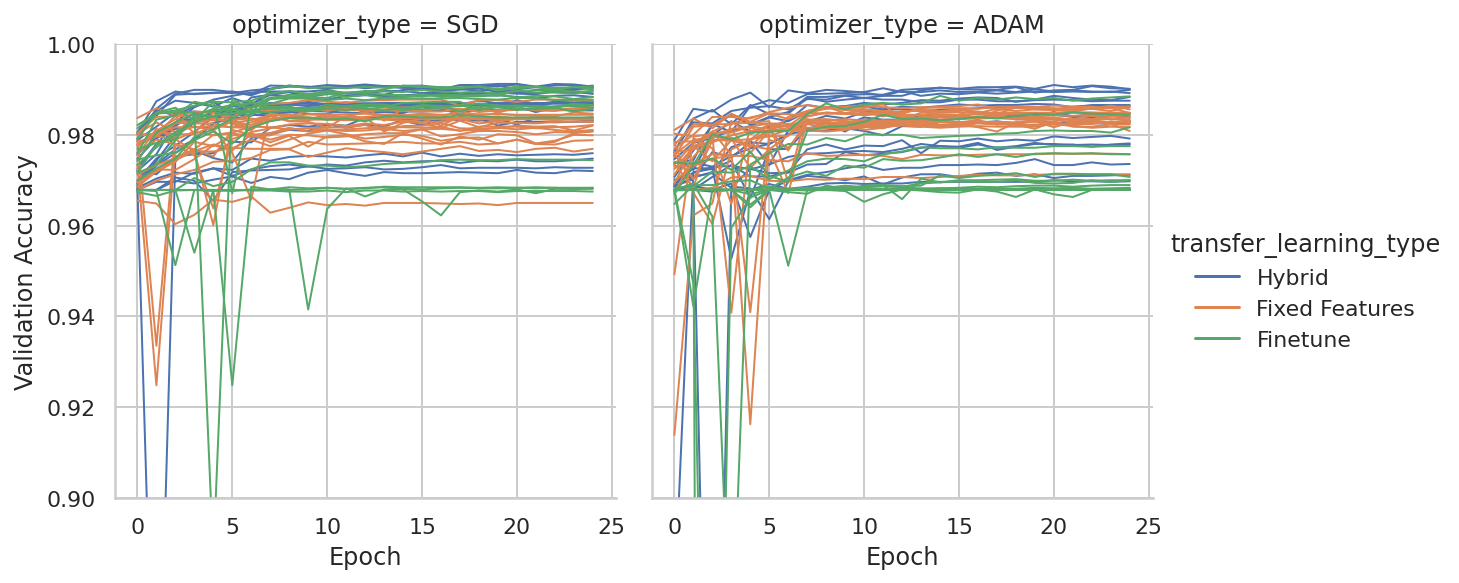

In [ ]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
#sns.set(rc={'figure.figsize':(13.7,11.27)})
sns.set_theme(style="whitegrid")
ax = sns.relplot(
    data=result_df.query("process=='train loss'"),
    x="epoch", y="model_performance", col="initial_lr",hue="transfer_learning_type", units="model_long_name",kind="line",
    estimator=None, lw=1,height=5, aspect=1
)
ax.set(
        xlabel='Epoch',
        ylabel='Training Loss')
plt.ylim(0, 3)

ax = sns.relplot(
    data=result_df.query("process=='validation accuracy'"),
    x="epoch", y="model_performance", col="initial_lr",hue="transfer_learning_type", units="model_long_name",kind="line",
    estimator=None, lw=1,height=5, aspect=1
)
ax.set(
        xlabel='Epoch',
        ylabel='Validation Accuracy')
plt.ylim(0.9, 1)

ax = sns.relplot(
    data=result_df.query("process=='train accuracy'"),
    x="epoch", y="model_performance", col="initial_lr",hue="transfer_learning_type", units="model_long_name",kind="line",
    estimator=None, lw=1,height=5, aspect=1
)
ax.set(
        xlabel='Epoch',
        ylabel='Training Accuracy')
plt.ylim(0.8, 1)


ax = sns.relplot(
    data=result_df.query("process=='train loss'"),
    x="epoch", y="model_performance", col="optimizer_type",hue="transfer_learning_type", units="model_long_name",kind="line",
    estimator=None, lw=1,height=4, aspect=1
)
ax.set(
        xlabel='Epoch',
        ylabel='Training Loss')
plt.ylim(0, 3)

ax = sns.relplot(
    data=result_df.query("process=='validation accuracy'"),
    x="epoch", y="model_performance", col="optimizer_type",hue="transfer_learning_type", units="model_long_name",kind="line",
    estimator=None, lw=1,height=4, aspect=1
)
ax.set(
        xlabel='Epoch',
        ylabel='Validation Accuracy')
plt.ylim(0.9, 1)






## Best performing models

In [6]:
pd.set_option('max_rows', 99999)
best_model_df =result_df.loc[result_df.process=='validation accuracy',['model_long_name','model_architecture',	'transfer_learning_type',	'optimizer_type','initial_lr','model_performance']].\
groupby(['model_architecture',	'transfer_learning_type',	'optimizer_type','initial_lr'],as_index=False).max('model_performance').\
sort_values('model_performance',ascending=False).round(4)
best_model_df.columns = ['Model Architecture','Transfer Learning Type','Optimizer','Learning Rate','Model Performance']
best_model_df

,Model Architecture,Transfer Learning Type,Optimizer,Learning Rate,Model Performance
118,wide_resnet50_2,Hybrid,SGD,0.010,0.9913
64,resnext101_32x8d,Hybrid,SGD,0.010,0.9912
60,resnext101_32x8d,Hybrid,ADAM,0.001,0.9910
4,densenet121,Finetune,SGD,0.010,0.9909
52,resnet50,Hybrid,SGD,0.010,0.9909
40,resnet50,Finetune,SGD,0.010,0.9909
12,densenet121,Hybrid,ADAM,0.001,0.9908
63,resnext101_32x8d,Hybrid,SGD,0.001,0.9903
48,resnet50,Hybrid,ADAM,0.001,0.9903
16,densenet121,Hybrid,SGD,0.010,0.9902


In [ ]:

g = sns.catplot(x="sex", y="total_bill",
                hue="smoker", col="time",
                data=tips, kind="bar",
                height=4, aspect=.7)

## Worst performing models

In [ ]:
result_df.loc[result_df.process=='validation accuracy',['model_long_name','model_architecture',	'transfer_learning_type',	'optimizer_type','initial_lr','model_performance']].\
groupby(['model_long_name','model_architecture',	'transfer_learning_type',	'optimizer_type','initial_lr']).max('model_performance').\
sort_values('model_performance',ascending=True).head(10)

,,,,,model_performance
model_long_name,model_architecture,transfer_learning_type,optimizer_type,initial_lr,
squeezenet1_0_hybridfixedfeatures_SGD_0pt1,squeezenet1_0,Hybrid,SGD,0.100,0.003104
vgg19_bn_finetune_SGD_0pt1,vgg19_bn,Finetune,SGD,0.100,0.003104
squeezenet1_0_finetune_SGD_0pt1,squeezenet1_0,Finetune,SGD,0.100,0.003104
squeezenet1_0_fixedfeatures_SGD_0pt1,squeezenet1_0,Fixed Features,SGD,0.100,0.966456
wide_resnet50_2_finetune_ADAM_0pt1,wide_resnet50_2,Finetune,ADAM,0.100,0.967888
resnet18_finetune_SGD_0pt1,resnet18,Finetune,SGD,0.100,0.967888
squeezenet1_0_finetune_ADAM_0pt1,squeezenet1_0,Finetune,ADAM,0.100,0.967888
vgg19_bn_finetune_ADAM_0pt001,vgg19_bn,Finetune,ADAM,0.001,0.967888
vgg19_bn_finetune_ADAM_0pt01,vgg19_bn,Finetune,ADAM,0.010,0.967888


In [ ]:
multiple_comparison=result_df.loc[result_df.process=='validation accuracy',['model_long_name','transfer_learning_type',	'optimizer_type','initial_lr','model_performance']].\
groupby(['model_long_name','transfer_learning_type',	'optimizer_type','initial_lr']).max('model_performance').\
groupby(['transfer_learning_type',	'optimizer_type','initial_lr'])[['model_performance']].describe()
multiple_comparison.index.names = ['Transfer Learning Type','Optimizer','Learning Rate']
multiple_comparison.columns = ['Count','Mean','Std','Min','25%','50%','75%','Max']
multiple_comparison.loc[:,['Mean','Std','Min','Max']].round(4)



Mean     Std     Min     Max
Transfer Learning Type Optimizer Learning Rate                                
Finetune               ADAM      0.001          0.9795  0.0074  0.9679  0.9887
                                 0.010          0.9694  0.0015  0.9679  0.9716
                                 0.100          0.9681  0.0004  0.9679  0.9690
                       SGD       0.001          0.9866  0.0013  0.9844  0.9882
                                 0.010          0.9876  0.0064  0.9747  0.9909
                                 0.100          0.6466  0.4985  0.0031  0.9686
Fixed Features         ADAM      0.001          0.9842  0.0015  0.9825  0.9866
                                 0.010          0.9835  0.0036  0.9760  0.9867
                                 0.100          0.9828  0.0052  0.9714  0.9869
                       SGD       0.001          0.9808  0.0021  0.9776  0.9839
                                 0.010          0.9848  0.0018  0.9822  0.9878
                                 0.100          0.9819  0.0070  0.9665  0.9863
Hybrid                 ADAM      0.001          0.9874  0.0049  0.9783  0.9910
                                 0.010          0.9798  0.0086  0.9679  0.9882
                                 0.100          0.9745  0.0068  0.9679  0.9869
                       SGD       0.001          0.9873  0.0015  0.9857  0.9903
                                 0.010          0.9894  0.0026  0.9838  0.9913
                                 0.100          0.8387  0.3685  0.0031  0.9876

In [ ]:
best_performance_per_model =result_df.loc[result_df.process=='validation accuracy',['model_long_name','transfer_learning_type',	'optimizer_type','initial_lr','model_performance']].\
groupby(['model_long_name','transfer_learning_type',	'optimizer_type','initial_lr'],as_index=False).max('model_performance')
best_performance_per_model.columns = ['Model Long Name','Transfer Learning Type','Optimizer','Learning Rate','Model Performance']
best_performance_per_model

,Model Long Name,Transfer Learning Type,Optimizer,Learning Rate,Model Performance
0,densenet121_finetune_ADAM_0pt001,Finetune,ADAM,0.001,0.988659
1,densenet121_finetune_ADAM_0pt01,Finetune,ADAM,0.010,0.970395
2,densenet121_finetune_ADAM_0pt1,Finetune,ADAM,0.100,0.968963
3,densenet121_finetune_SGD_0pt001,Finetune,SGD,0.001,0.987346
4,densenet121_finetune_SGD_0pt01,Finetune,SGD,0.010,0.990928
...,...,...,...,...,...
115,wide_resnet50_2_hybridfixedfeatures_ADAM_0pt01,Hybrid,ADAM,0.010,0.986391
116,wide_resnet50_2_hybridfixedfeatures_ADAM_0pt1,Hybrid,ADAM,0.100,0.972663
117,wide_resnet50_2_hybridfixedfeatures_SGD_0pt001,Hybrid,SGD,0.001,0.987108
118,wide_resnet50_2_hybridfixedfeatures_SGD_0pt01,Hybrid,SGD,0.010,0.991286


Text(0.5, 0.98, 'EFFECT OF OPTIMIZER AND LEARNING RATE ON TRANSFER LEARNING TYPE')

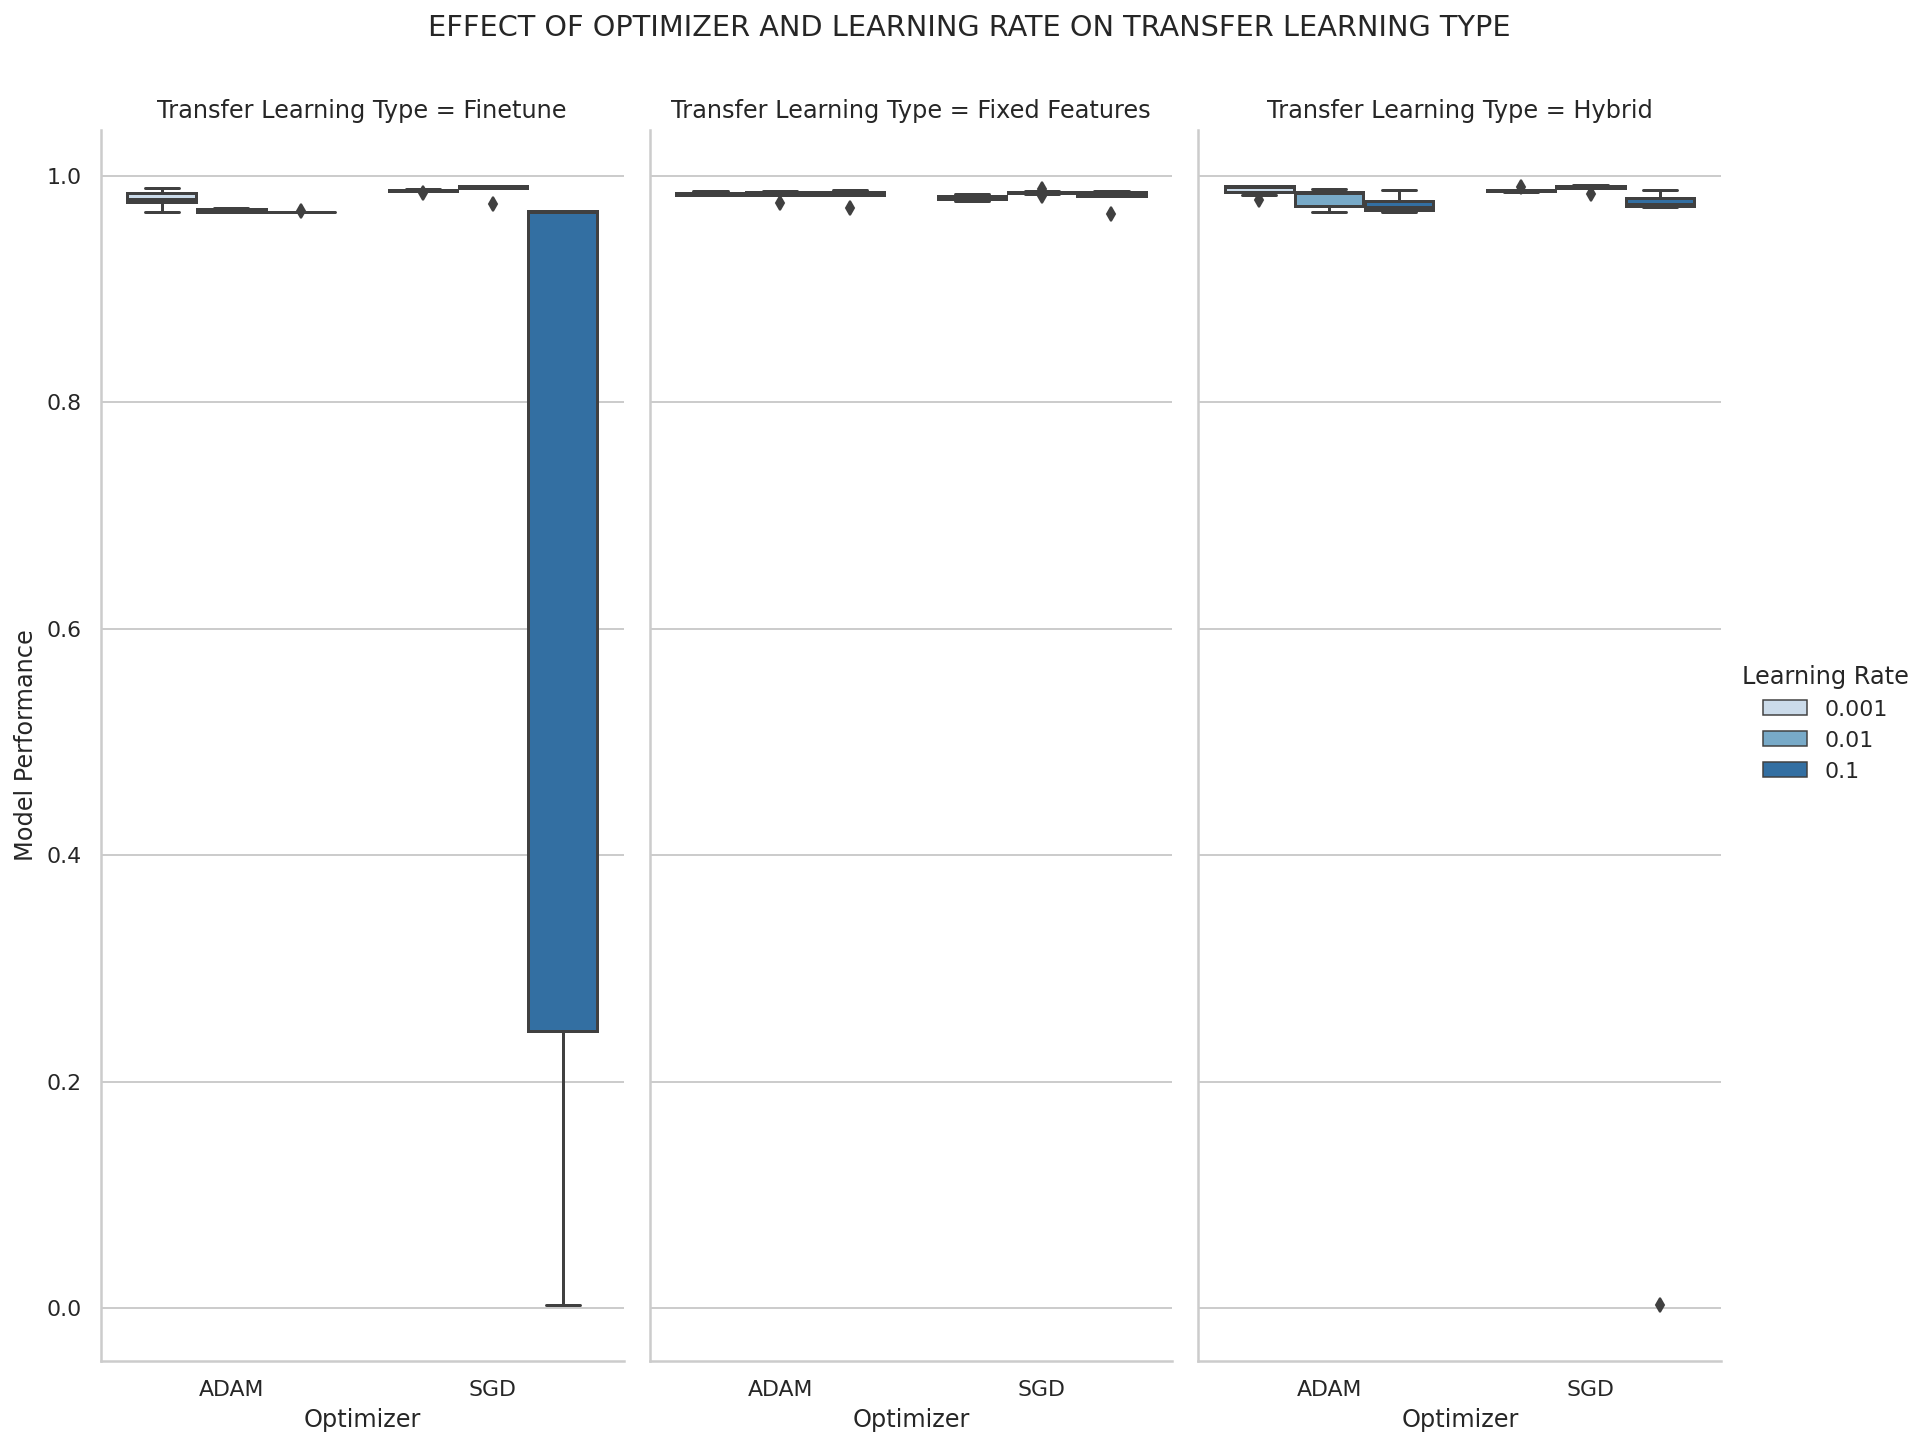

In [ ]:
 %config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_theme(style="whitegrid")
g = sns.catplot(x='Optimizer', y='Model Performance',
                 hue='Learning Rate', col='Transfer Learning Type',
                 data=best_performance_per_model, kind="box",
                 height=10, aspect=.4,palette='Blues')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('EFFECT OF OPTIMIZER AND LEARNING RATE ON TRANSFER LEARNING TYPE')

Hybrid between using pre-trained models as fixed features and 

In [ ]:
np.sort(result_df['model_architecture'].unique())
len(result_df)/25

480.0

In [ ]:
np.sort(result_df['model_architecture'].unique())
pd.DataFrame({'Model Name':['densenet121', 'resnet18', 'resnet50', 'resnext101_32x8d','squeezenet1_0', 'vgg19_bn', 'wide_resnet50_2'],
 'Number of parameters': ['','','','','','','68.9M']
 })

,Model Name,Number of parameters
0,densenet121,
1,resnet18,
2,resnet50,
3,resnext101_32x8d,
4,squeezenet1_0,
5,vgg19_bn,
6,wide_resnet50_2,68.9M


Wide Residual networks simply have increased number of channels compared to ResNet. Otherwise the architecture is the same. Deeper ImageNet models with bottleneck block have increased number of channels in the inner 3x3 convolution.

In [ ]:
train_multiple_variants(inputs, device, writer_path,
                            pretrained_model_name=['resnet50'],
                            variant=["finetune"], 
                            number_of_classes= 12,
                            INITIAL_LR=[0.01],
                            number_of_pochs=35, 
                            CHECKPOINT_PATH="runs",
                            step_after = 10,
                            proportion_fixed = 0.5,
                            optimization=['SGD'],
                            dataset_sizes = 0,
                            train_from_scratch = True,
                            data_dir = "",
                            image_index_file_location = ""
                            ):
  
  try:
    model_results = {}
    for model_type in pretrained_model_name:
      for transfer_ln_type in variant:
        for optim_type in optimization:
          for learning_rate_val in INITIAL_LR:
            lr_str = str(learning_rate_val)
            lr_str = lr_str.replace(".", "pt")

            model_name = '{}_{}_{}_{}.h5'.format(model_type,transfer_ln_type,optim_type,lr_str)


            model_val_acc = set_up_training_schedule(inputs=inputs,
                                                model_name = model_type, 
                                                number_of_classes= number_of_classes,
                                                device=device, 
                                                INITIAL_LR=learning_rate_val, 
                                                writer=writer, 
                                                step_after = step_after,
                                                transfer_learning_type = transfer_ln_type,
                                                proportion_fixed = proportion_fixed,
                                                number_of_pochs=number_of_pochs, 
                                                model_save_name = model_name,
                                                CHECKPOINT_PATH=CHECKPOINT_PATH,
                                                optimizer_to_use = optim_type,
                                                dataset_sizes = dataset_sizes,
                                                return_best_results_only = True,
                                                train_from_scratch = train_from_scratch,
                                                data_dir = data_dir,
                                                image_index_file_location = image_index_file_location)
            model_results.update({model_name : model_val_acc})

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_index_file_location = '/content/drive/My Drive/ECE590-Final-Project/Data/image_index_v3.csv'
data_dir = '/content/drive/My Drive/ECE590-Final-Project/Data/'


image_datasets = {x: LoadDataset(text_file =image_index_file_location, root_dir = data_dir,
                                 transform=data_transforms[x],train_or_val=x)
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=256,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['val'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model_ft, input_size = initialize_model(model_name = 'wide_resnet50_2', 
                                        num_classes = len(class_names), 
                                        feature_extract='hybridfixedfeatures', 
                                        use_pretrained=True,
                                        proportion_fixed=0.5)


In [ ]:
model_ft_resnext101, input_size = initialize_model(model_name = 'resnext101_32x8d', 
                                        num_classes = len(class_names), 
                                        feature_extract='hybridfixedfeatures', 
                                        use_pretrained=True,
                                        proportion_fixed=0.5)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


In [ ]:
model_ft, start_epoch, current_learning_rate = load_training_starting_point(model_ft,
                                                                         CKPT_PATH="/content/drive/My Drive/ECE590-Final-Project/saved_models/wide_resnet50_2_hybridfixedfeatures_SGD_0pt01.h5",
                                                                         train_from_scratch = False,
                                                                         INITIAL_LR = 0.01)


Successfully loaded checkpoint: /content/drive/My Drive/ECE590-Final-Project/saved_models/wide_resnet50_2_hybridfixedfeatures_SGD_0pt01.h5
Starting from epoch 20 
Starting from learning rate 0.000100:


In [ ]:
model_ft_resnext101, start_epoch, current_learning_rate = load_training_starting_point(model_ft_resnext101,
                                                                         CKPT_PATH="/content/drive/My Drive/ECE590-Final-Project/saved_models/resnext101_32x8d_hybridfixedfeatures_SGD_0pt01.h5",
                                                                         train_from_scratch = False,
                                                                         INITIAL_LR = 0.01)


Successfully loaded checkpoint: /content/drive/My Drive/ECE590-Final-Project/saved_models/resnext101_32x8d_hybridfixedfeatures_SGD_0pt01.h5
Starting from epoch 21 
Starting from learning rate 0.000010:


In [ ]:
model_ft = model_ft.to(device)

In [ ]:
model_ft_resnext101 = model_ft_resnext101.to(device)

Starting batch: 1


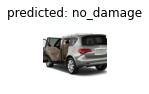

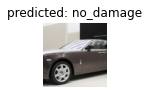

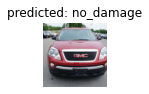

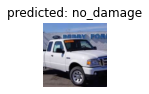

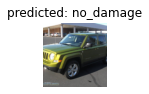

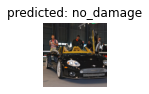

Starting batch: 2
Starting batch: 3
Starting batch: 4
Starting batch: 5
Starting batch: 6
Starting batch: 7
Starting batch: 8
Starting batch: 9
Starting batch: 10
Starting batch: 11
Starting batch: 12
Starting batch: 13
Starting batch: 14
Starting batch: 15
Starting batch: 16
Starting batch: 17
Starting batch: 18
Starting batch: 19
Starting batch: 20
Starting batch: 21
Starting batch: 22
Starting batch: 23
Starting batch: 24
Starting batch: 25
Starting batch: 26
Starting batch: 27
Starting batch: 28
Starting batch: 29
Starting batch: 30
Starting batch: 31
Starting batch: 32
Starting batch: 33


In [ ]:
actual_labels, pred_labels = visualize_model(model_ft,device,dataloaders,class_names, num_images=6,return_only_images=False)

Starting batch: 1


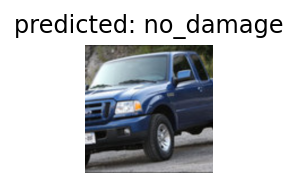

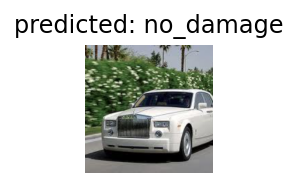

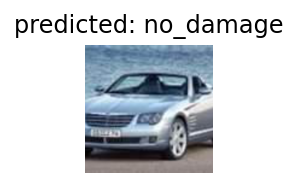

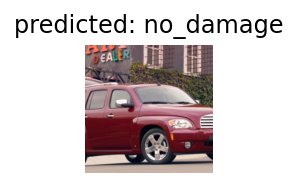

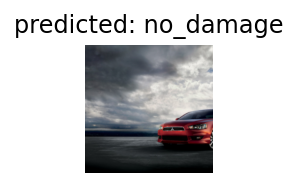

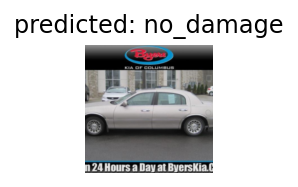

Starting batch: 2
Starting batch: 3
Starting batch: 4
Starting batch: 5
Starting batch: 6
Starting batch: 7
Starting batch: 8
Starting batch: 9
Starting batch: 10
Starting batch: 11
Starting batch: 12
Starting batch: 13
Starting batch: 14
Starting batch: 15
Starting batch: 16
Starting batch: 17
Starting batch: 18
Starting batch: 19
Starting batch: 20
Starting batch: 21
Starting batch: 22
Starting batch: 23
Starting batch: 24
Starting batch: 25
Starting batch: 26
Starting batch: 27
Starting batch: 28
Starting batch: 29
Starting batch: 30
Starting batch: 31
Starting batch: 32
Starting batch: 33


In [ ]:
actual_labels_resnext, pred_labels_resnext = visualize_model(model_ft_resnext101,device,dataloaders,class_names, num_images=6,return_only_images=False)

In [ ]:
directory = r'/content/drive/My Drive/ECE590-Final-Project/saved_models/saved_training_points/'
pd.DataFrame({'ActualClass':actual_labels,'PredictedLabel':pred_labels}).to_csv(os.path.join(directory, 'final_model_predictions.csv'), index = False)

In [ ]:
directory = r'/content/drive/My Drive/ECE590-Final-Project/saved_models/saved_training_points/'
pd.DataFrame({'ActualClass':actual_labels_resnext,'PredictedLabel':pred_labels_resnext}).to_csv(os.path.join(directory, 'final_model_predictions_resnext.csv'), index = False)

In [ ]:
predictions = pd.read_csv('/content/drive/My Drive/ECE590-Final-Project/saved_models/saved_training_points/final_model_predictions.csv')
actual_labels = predictions['ActualClass']
pred_labels = predictions['PredictedLabel']

In [ ]:
predictions_resnext = pd.read_csv('/content/drive/My Drive/ECE590-Final-Project/saved_models/saved_training_points/final_model_predictions_resnext.csv')
actual_labels_resnext = predictions_resnext['ActualClass']
pred_labels_resnext = predictions_resnext['PredictedLabel']

In [ ]:
from sklearn.metrics import f1_score
print(f1_score(actual_labels, pred_labels, average='micro'))
f1_score(actual_labels, pred_labels, average='macro')

0.9904500417810672


0.7094946176532402

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual_labels, pred_labels)
cm

array([[  22,    3,    0,    0,    0,    0,    0,    0,    1,    0],
       [   1,   14,    0,    0,    0,    0,    0,    2,    1,    0],
       [   0,    0,   22,    5,    0,    1,    0,    3,    6,    0],
       [   0,    0,    6,   19,    0,    0,    0,    0,    4,    0],
       [   0,    1,    2,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,   22,    0,    0,    4,    0],
       [   1,    1,    0,    0,    0,    0,   12,    0,    2,    0],
       [   0,    1,    1,    0,    0,    2,    5,   68,   10,    3],
       [   0,    0,    2,    1,    0,    0,    3,    1, 8097,    4],
       [   0,    0,    0,    0,    0,    0,    1,    0,    2,   21]])

In [ ]:
cm_resnext = confusion_matrix(actual_labels_resnext, pred_labels_resnext)
cm_resnext

array([[  21,    4,    0,    0,    0,    0,    0,    0,    1,    0],
       [   1,   11,    0,    0,    0,    0,    0,    0,    6,    0],
       [   0,    0,   26,    3,    0,    1,    0,    2,    5,    0],
       [   0,    0,    4,   21,    0,    1,    0,    0,    3,    0],
       [   0,    1,    2,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    1,    0,    0,   20,    0,    0,    4,    1],
       [   1,    1,    0,    0,    0,    0,   11,    0,    2,    1],
       [   0,    0,    1,    0,    0,    2,    5,   63,   17,    2],
       [   0,    0,    2,    2,    0,    0,    3,    3, 8094,    4],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,   24]])

In [ ]:
print(np.unique(pred_labels))
print(np.unique(actual_labels))
print(class_names[np.unique(actual_labels)])

[ 0  1  2  3  6  7  8  9 10]
[ 0  1  2  3  4  6  7  8  9 10]
['bumper_dent' 'bumper_scratch' 'door_dent' 'door_scratch' 'fender_dent'
 'glass_shatter' 'head_lamp' 'multi_area_damage' 'no_damage' 'tail_lamp']


In [ ]:
class_names

array(['bumper_dent', 'bumper_scratch', 'door_dent', 'door_scratch',
       'fender_dent', 'fender_scratch', 'glass_shatter', 'head_lamp',
       'multi_area_damage', 'no_damage', 'tail_lamp'], dtype='<U50')

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


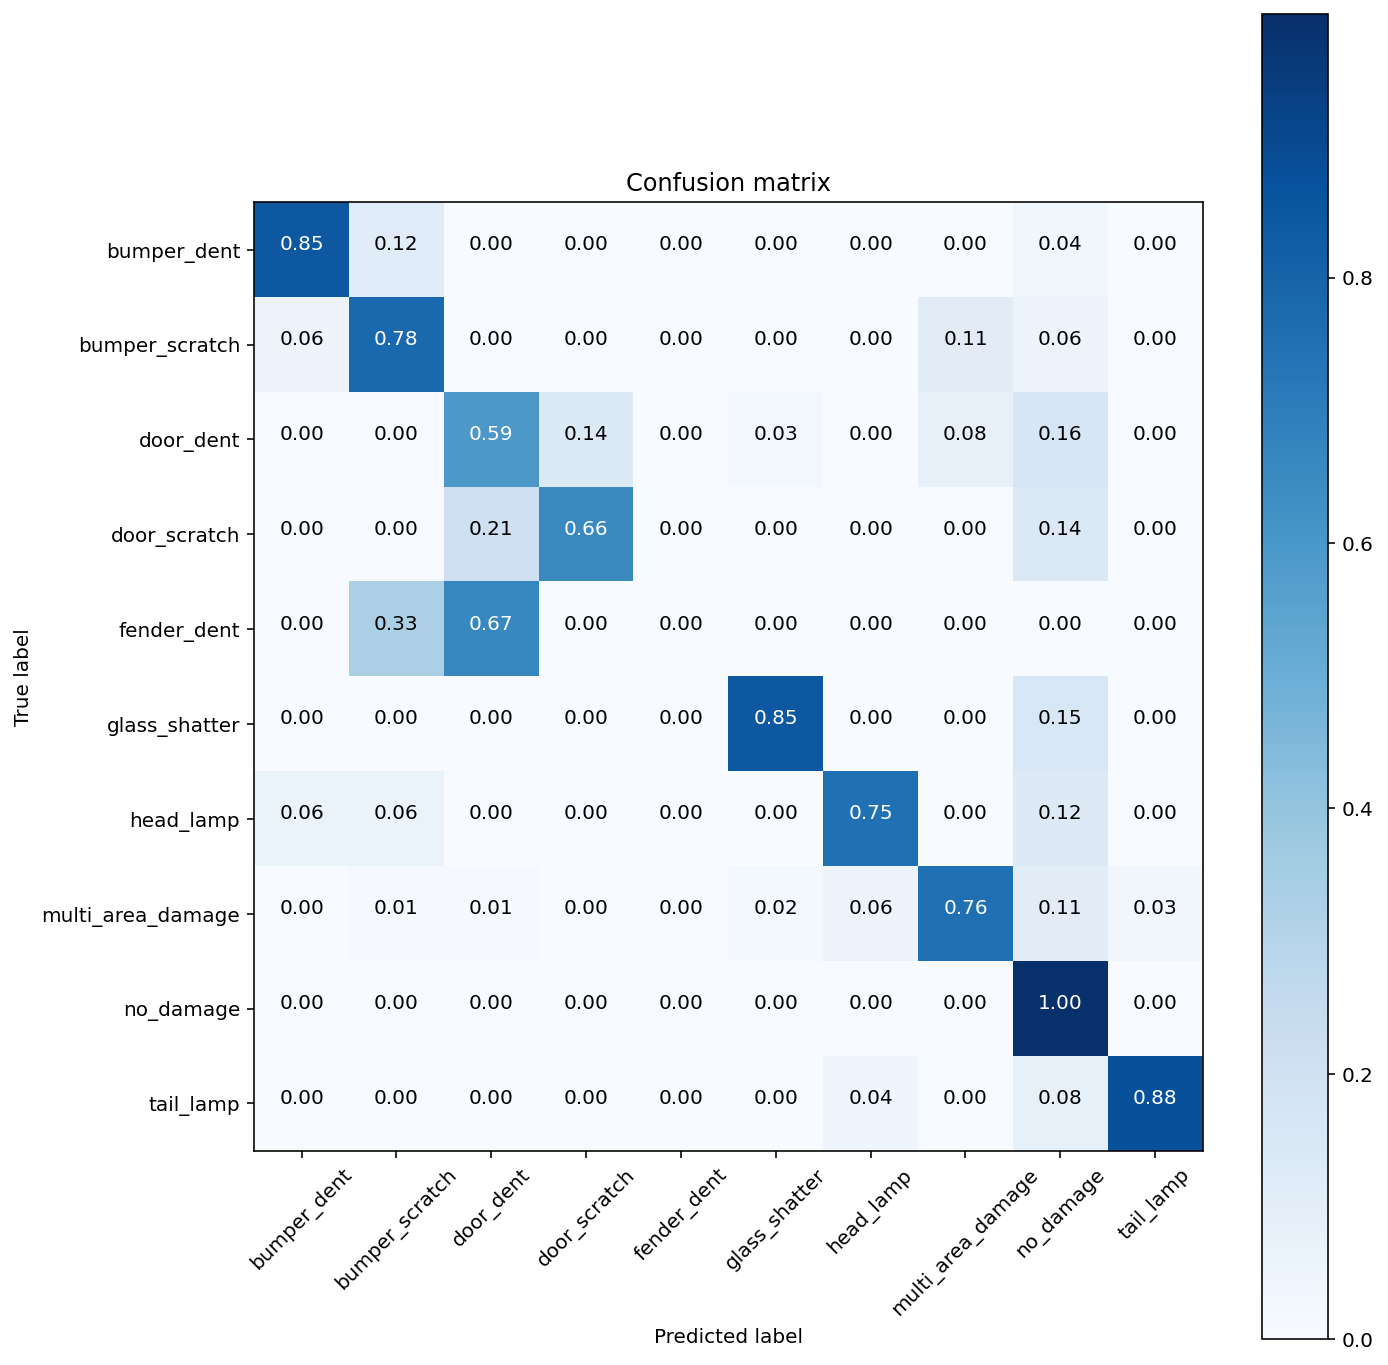

In [ ]:
 %config InlineBackend.figure_format = 'retina'
 plt.figure(figsize=(10,10))
 plot_confusion_matrix(cm, class_names[np.unique(actual_labels)], normalize=True, title='Confusion matrix', cmap=plt.cm.Blues)

In [ ]:
image_datasets['val'].classes

array(['bumper_dent', 'bumper_scratch', 'door_dent', 'door_scratch',
       'fender_dent', 'fender_scratch', 'glass_shatter', 'head_lamp',
       'multi_area_damage', 'no_damage', 'tail_lamp'], dtype='<U50')

In [ ]:
image_datasets['train'].classes

array(['bumper_dent', 'bumper_scratch', 'door_dent', 'door_scratch',
       'fender_dent', 'fender_scratch', 'glass_shatter', 'head_lamp',
       'multi_area_damage', 'no_damage', 'tail_lamp'], dtype='<U50')

In [ ]:
image_index = np.genfromtxt(image_index_file_location,dtype=['U50','U50','U50'], delimiter=',',names=True)


class_lbls_train = image_index[image_index['subset']=='T']['class']
class_lbls_val = image_index[image_index['subset']=='V']['class']

In [ ]:
np.unique(class_lbls_val)

array(['bumper_dent', 'bumper_scratch', 'door_dent', 'door_scratch',
       'fender_dent', 'glass_shatter', 'head_lamp', 'multi_area_damage',
       'no_damage', 'tail_lamp'], dtype='<U50')

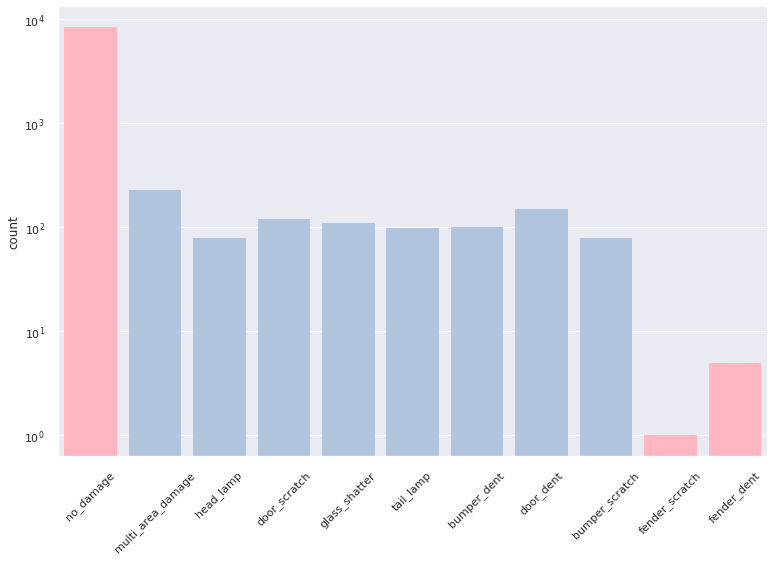

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12.7,8.27)})

#plt_f1 = sns.countplot(x =class_lbls_train,palette="pastel", edgecolor=".6")
plt_f1 = sns.countplot(x =class_lbls_train,color="lightsteelblue", edgecolor=".6")
plt_f1.set_xticklabels(plt_f1.get_xticklabels(),rotation=45)
plt_f1.set_yscale("log")
plt_f1.title('Training Set Image Class Distribution')

for bar in plt_f1.patches:
  if (bar.get_height() < 50) or (bar.get_height() > 1000):
      bar.set_color('lightpink')    
  else:
      bar.set_color('lightsteelblue')


Text(0.5, 1.0, 'Testing Set Image Class Distribution')

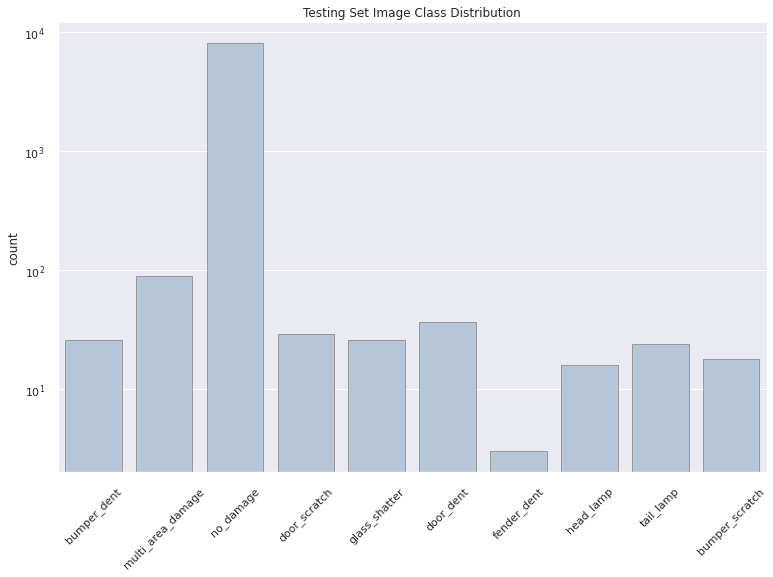

In [ ]:
sns.set(rc={'figure.figsize':(12.7,8.27)})
#plt_f1 = sns.countplot(x =class_lbls_train,palette="pastel", edgecolor=".6")
plt_f1 = sns.countplot(x =class_lbls_val,color="lightsteelblue", edgecolor=".6")
plt_f1.set_xticklabels(plt_f1.get_xticklabels(),rotation=45)
plt_f1.set_yscale("log")
plt_f1.set_title('Testing Set Image Class Distribution')

for bar in plt_f1.patches:
  if (bar.get_height() < 10) or (bar.get_height() > 1000):
      bar.set_color('lightpink')    
  else:
      bar.set_color('lightsteelblue')

In [ ]:
np.unique(class_lbls_train)

array(['bumper_dent', 'bumper_scratch', 'door_dent', 'door_scratch',
       'fender_dent', 'fender_scratch', 'glass_shatter', 'head_lamp',
       'multi_area_damage', 'no_damage', 'tail_lamp'], dtype='<U50')

In [ ]:
plotting_df = pd.DataFrame(image_index)
class_lbls_train_df = pd.DataFrame(image_index[image_index['subset']=='T'])
class_lbls_val_df = pd.DataFrame(image_index[image_index['subset']=='V'])
plotting_df.head()


,image,class,subset
0,cars_train/00001.jpg,no_damage,T
1,cars_train/00002.jpg,no_damage,T
2,cars_train/00003.jpg,no_damage,T
3,cars_train/00004.jpg,no_damage,T
4,cars_train/00005.jpg,no_damage,T


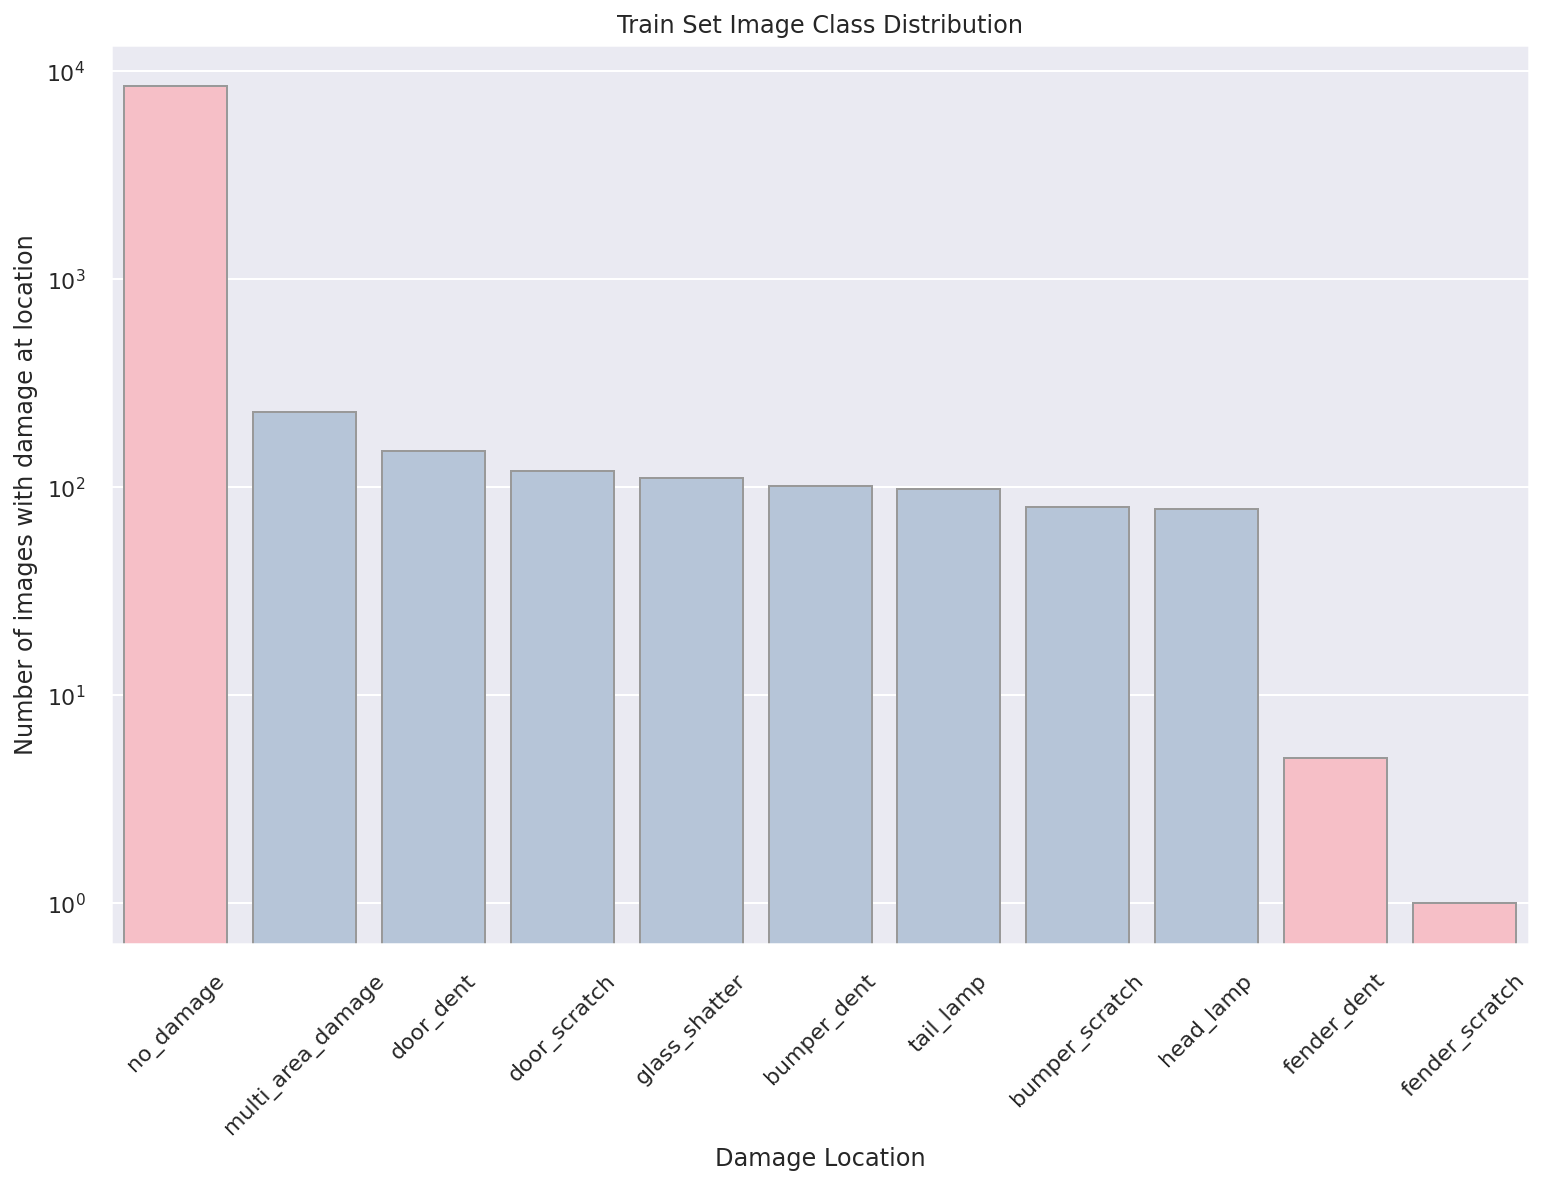

In [ ]:
%config InlineBackend.figure_format = 'retina'
color_pal = []
order_lab = plotting_df['class'].value_counts().index
for freq_count in class_lbls_train_df['class'].value_counts():
  if (freq_count<10) or (freq_count>1000):
    color_pal.append('lightpink')
  else:
    color_pal.append('lightsteelblue')

sns.set(rc={'figure.figsize':(12.7,8.27)})
#plt_f1 = sns.countplot(x =class_lbls_train,palette="pastel", edgecolor=".6")
plt_f1 = sns.countplot(x ='class',data=class_lbls_train_df,palette=color_pal,order=order_lab, edgecolor=".6")
plt_f1.set_xticklabels(plt_f1.get_xticklabels(),rotation=45)
plt_f1.set_title('Train Set Image Class Distribution')
plt_f1.set_xlabel('Damage Location')
plt_f1.set_ylabel('Number of images with damage at location')
plt_f1.set_yscale("log")

plt_f1.figure.savefig("train_data_class_distribution.png",pad_inches=0.2)

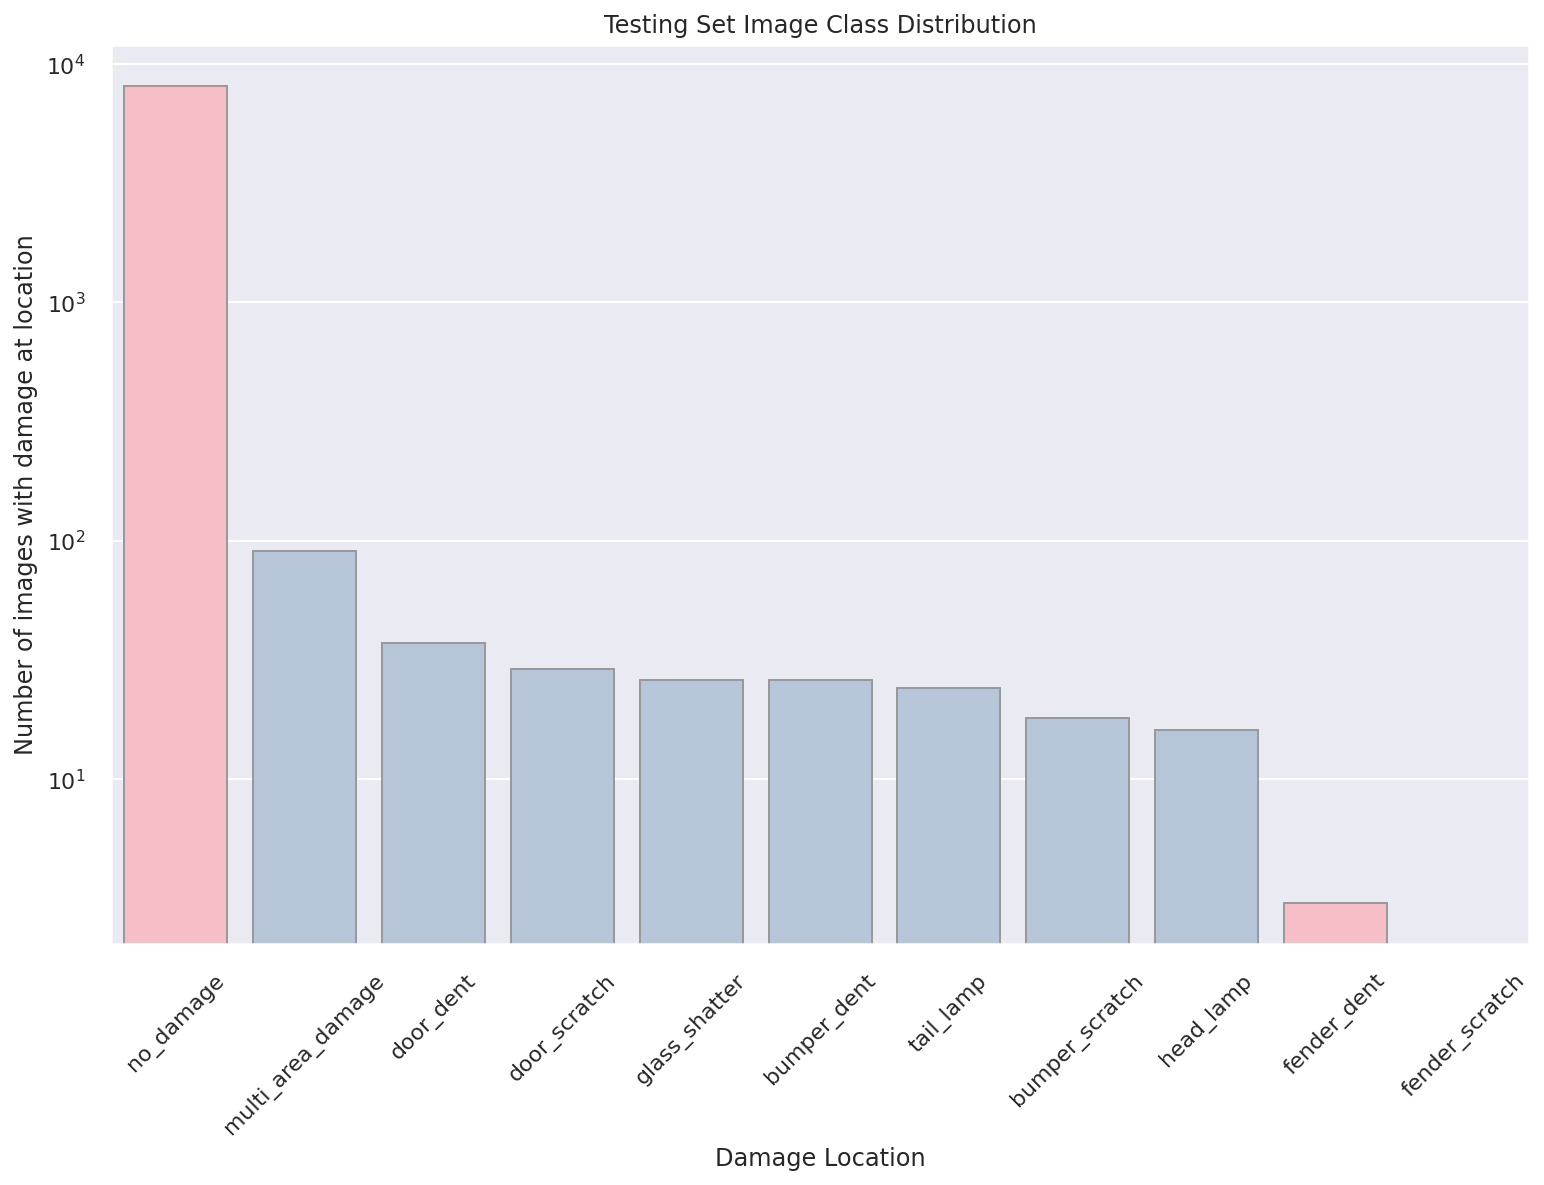

In [ ]:
#plotting_df['class'].value_counts().index
%config InlineBackend.figure_format = 'retina'
color_pal = []
order_lab = plotting_df['class'].value_counts().index
for freq_count in class_lbls_val_df['class'].value_counts():
  if (freq_count<10) or (freq_count>1000):
    color_pal.append('lightpink')
  else:
    color_pal.append('lightsteelblue')

sns.set(rc={'figure.figsize':(12.7,8.27)})
#plt_f1 = sns.countplot(x =class_lbls_train,palette="pastel", edgecolor=".6")
plt_f1 = sns.countplot(x ='class',data=class_lbls_val_df,palette=color_pal,order=order_lab, edgecolor=".6")
plt_f1.set_xticklabels(plt_f1.get_xticklabels(),rotation=45)
plt_f1.set_title('Testing Set Image Class Distribution')
plt_f1.set_xlabel('Damage Location')
plt_f1.set_ylabel('Number of images with damage at location')
plt_f1.set_yscale("log")

plt_f1.figure.savefig("test_data_class_distribution.png")



  

In [ ]:
sns.heatmap(cm,cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

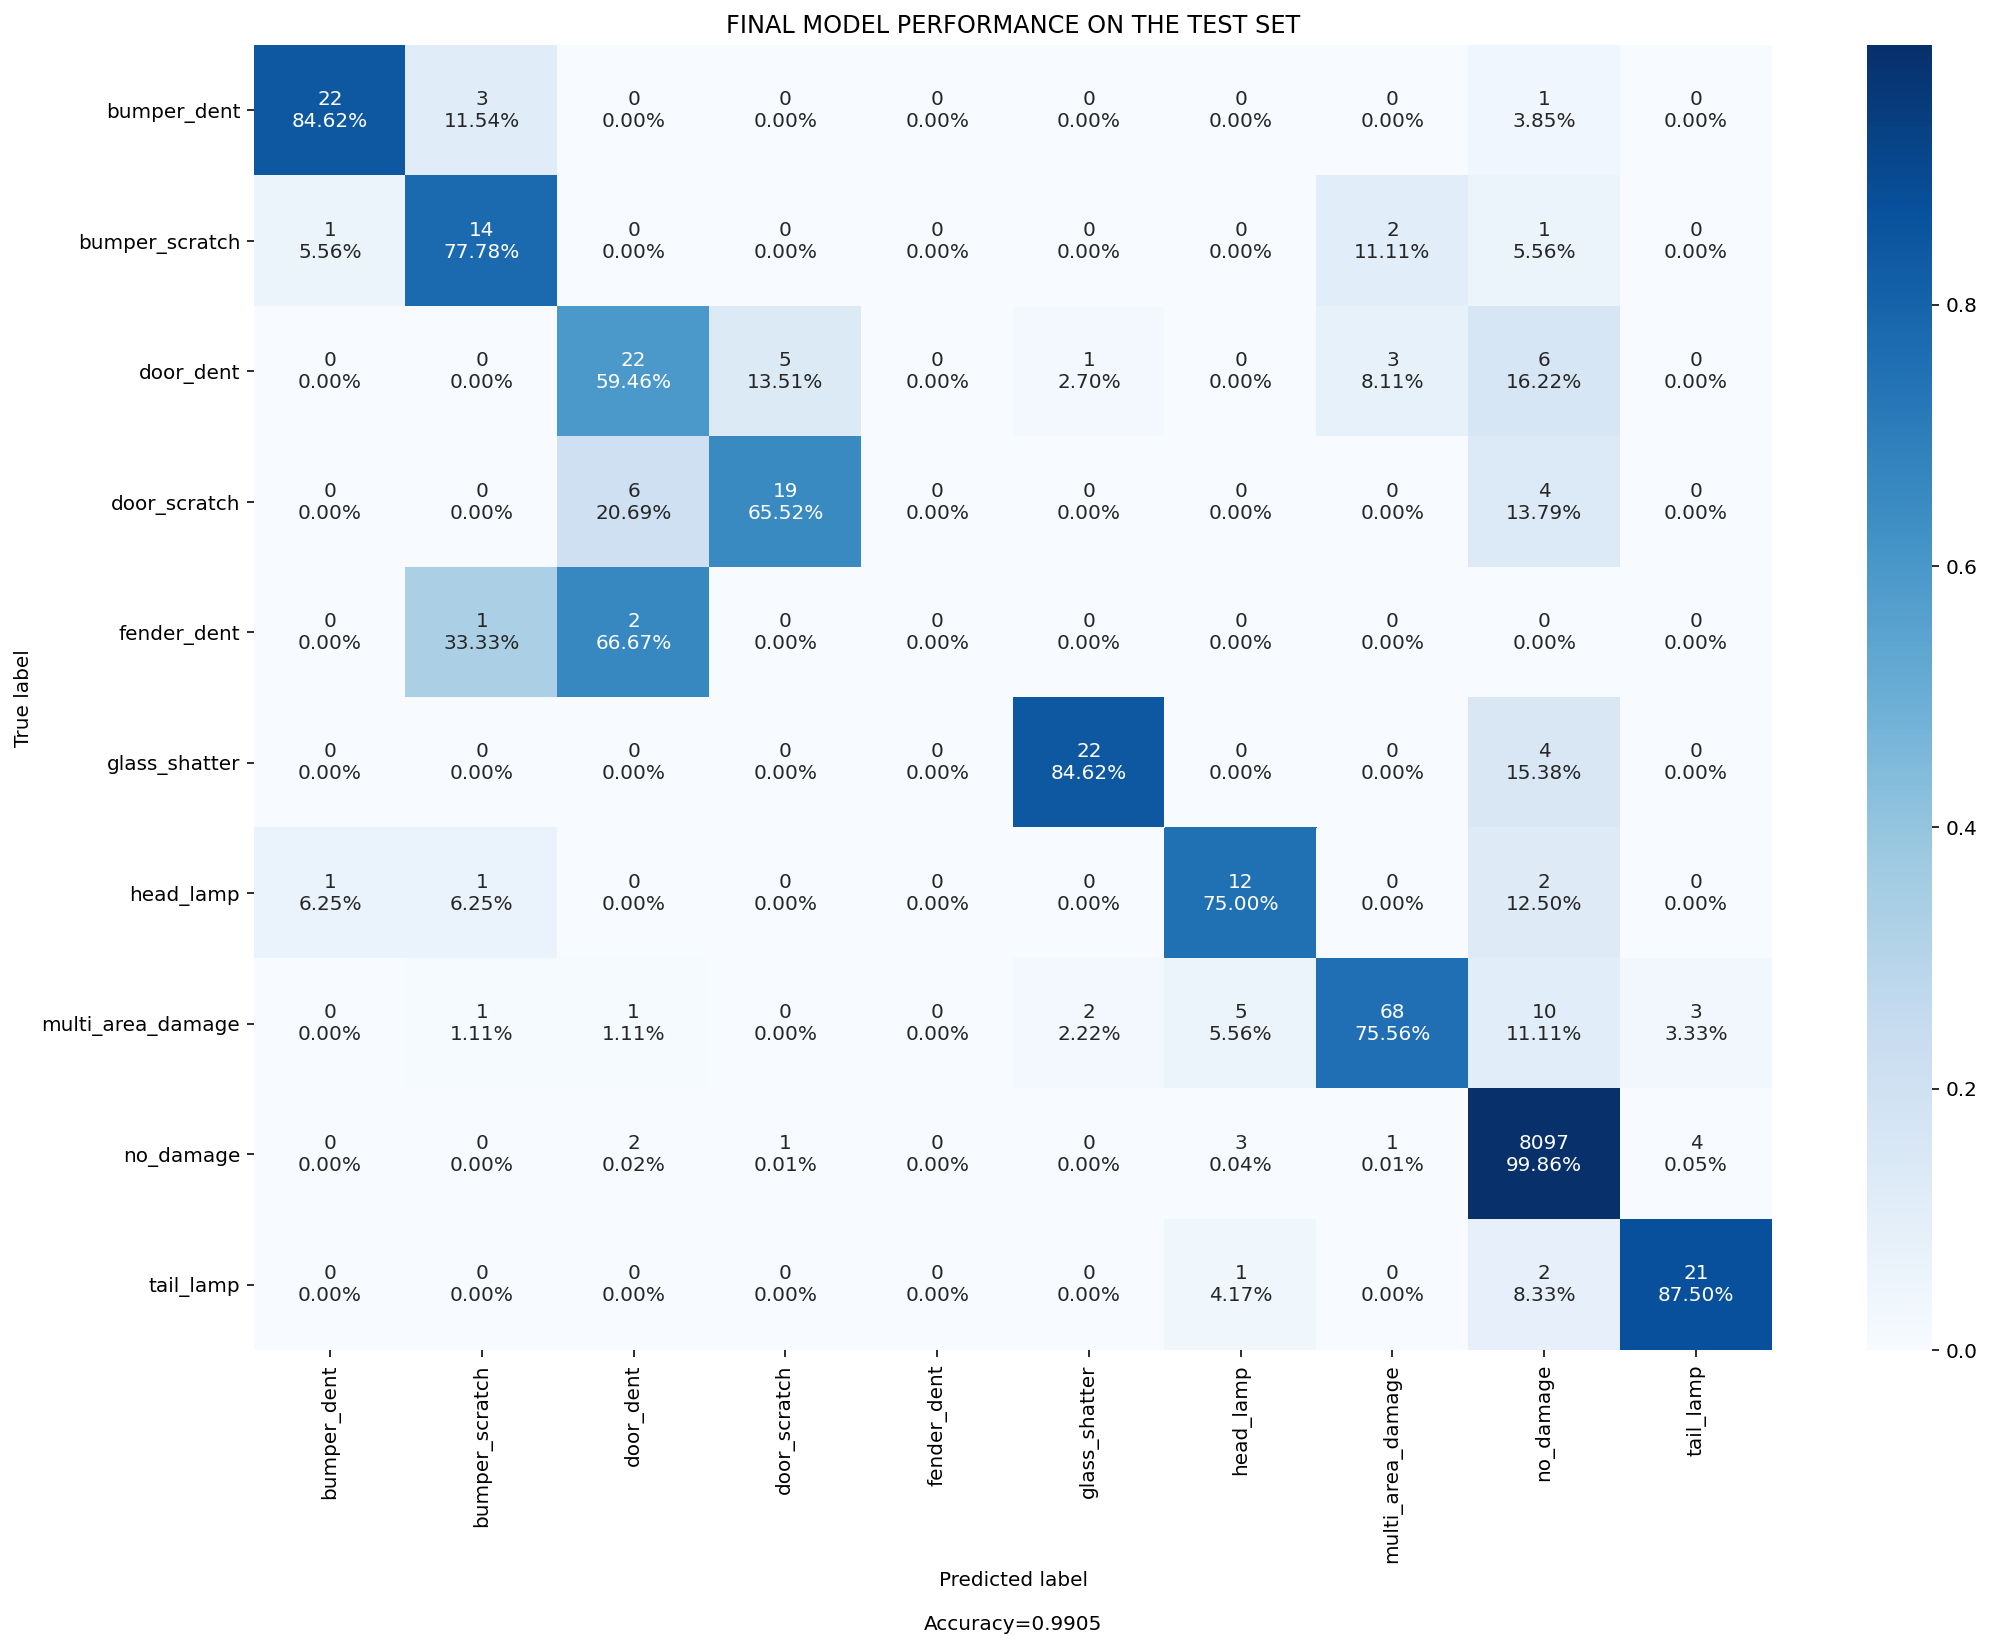

In [ ]:
%config InlineBackend.figure_format = 'retina'
from tools.confusion_matrix_custom import *
make_confusion_matrix(cm, figsize=(17,12), cbar=True,count=True,categories=np.unique(class_lbls_val),title="FINAL MODEL PERFORMANCE ON THE TEST SET")